# <u>Geometric image classification substructure of the Hornsund Fjord: Binary statistics of sea ice area (For Loop) </u>  <br /> <sub> <span style="font-size:smaller;"> Jullian C.B. Williams </span> </sub> <br /> <sub> <span style="font-size:smaller;"> *Polish Academy of Sciences, Institute of Geophysics, Warsaw, Poland* </span> </sub>


In [2]:
import emoji #<---- Death and taxes are for certain. Try to have fun before you're 6 feet too far under to.
from rich.console import Console #<---- Ditto.

import fiona
import random
import warnings
import argparse, os
import pyarrow as pa
from shapely.geometry import box
from shapely.geometry import shape
from shapely.geometry import Polygon
from shapely.affinity import translate

import numpy as np
import pandas as pd
from osgeo import ogr
from osgeo import gdal #<---- to geospatial env.
import geopandas as gpd

from PIL import Image


import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.plot import show_hist 
from rasterstats import zonal_stats
from rasterio.features import shapes
from rasterio.plot import adjust_band
from rasterio.features import rasterize

import seaborn as sns
import matplotlib.image
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

from spectral import *
from sklearn import svm
from scipy import stats
from scipy import ndimage
from sklearn.svm import SVC
from scipy.ndimage import zoom
from scipy.ndimage import sobel
from scipy.stats import entropy
import spectral.io.envi as envi #run PCA
from sklearn.svm import LinearSVC
from skimage import io, transform # from scipy.misc import imresize  <---- here...we...go..
from skimage.morphology import disk #manage disk while running.
from skimage.segmentation import slic
from skimage.util import img_as_ubyte #Avoid precision loss converting image of type float32 to uint8 as required by rank filters.
from skimage.filters.rank import entropy #for GLCM entropy.
from sklearn.pipeline import make_pipeline
from skimage.segmentation import chan_vese
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from skimage.feature import graycomatrix, graycoprops # from skimage.feature import greycomatrix, greycoprops <--- depreciated or..? lang.
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

### SVM

In [3]:
input_dir = "C:/Users/jullian.williams/Desktop/12_winter/"
output_dir = "C:/Users/jullian.williams/Desktop/date_/"

dataframes = []

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.tif')):
            input_path = os.path.join(subdir, filename)
            output_path = os.path.join(output_dir, filename.replace(".tif", ".csv"))
             
            with rio.open(input_path) as src_:
                profile = src_.profile  # Save metadata
                transform_ = src_.transform
                crs_=src_.crs
                b1_ = src_.read(1)
                
                def image_to_geodataframe(image_array, transform, crs):
            # Generate shapes (polygons) from the raster array
                    shapes_generator = shapes(image_array, transform=transform_)
                    
                    # Create a GeoDataFrame
                    geometries = []
                    values = []
                    for geom, value in shapes_generator:
                        geometries.append(shape(geom))
                        values.append(value)

                        name, ext = os.path.splitext(filename)
                        raftposition = 8
                    
                        # Create the new file name
                        file_name = f"{filename[:raftposition]}"
                                
                            
                    gdf = gpd.GeoDataFrame({'value': values, 'geometry': geometries, 'date':file_name}, crs=crs_)
                    
                    return gdf 
                    
            gdf = image_to_geodataframe(b1_, transform=transform_, crs=crs_)


            gdf['date'] = pd.to_datetime(gdf['date'])
            gdf['area'] = gdf.geometry.area
            gdf['perimeter'] = gdf.geometry.length
            gdf['centroid'] = gdf.geometry.centroid
            # Extract latitude and longitude from centroids
            gdf['longitude'] = gdf.centroid.x
            gdf['latitude'] = gdf.centroid.y
            gdf.set_crs(epsg=32633, inplace=True)

            dataframes.append(gdf)





In [4]:
dataframes

[      value                                           geometry       date  \
 0       0.0  POLYGON ((499175 8559025, 499175 8558975, 4992... 2012-01-02   
 1       0.0  POLYGON ((499525 8559025, 499525 8558925, 4995... 2012-01-02   
 2       0.0  POLYGON ((499675 8559025, 499675 8558925, 4997... 2012-01-02   
 3       0.0  POLYGON ((499775 8558975, 499775 8558925, 4998... 2012-01-02   
 4       0.0  POLYGON ((499475 8558925, 499475 8558875, 4995... 2012-01-02   
 ...     ...                                                ...        ...   
 1963    0.0  POLYGON ((505125 8531075, 505125 8530975, 5051... 2012-01-02   
 1964    1.0  POLYGON ((498975 8559025, 498975 8558475, 4990... 2012-01-02   
 1965    0.0  POLYGON ((505275 8531025, 505275 8530975, 5053... 2012-01-02   
 1966    0.0  POLYGON ((505975 8531025, 505975 8530975, 5061... 2012-01-02   
 1967    0.0  POLYGON ((507275 8531075, 507275 8531025, 5072... 2012-01-02   
 
              area  perimeter                        centroid 

In [5]:
xd = pd.concat(dataframes, ignore_index=True)
print(xd)

        value                                           geometry       date  \
0         0.0  POLYGON ((499175 8559025, 499175 8558975, 4992... 2012-01-02   
1         0.0  POLYGON ((499525 8559025, 499525 8558925, 4995... 2012-01-02   
2         0.0  POLYGON ((499675 8559025, 499675 8558925, 4997... 2012-01-02   
3         0.0  POLYGON ((499775 8558975, 499775 8558925, 4998... 2012-01-02   
4         0.0  POLYGON ((499475 8558925, 499475 8558875, 4995... 2012-01-02   
...       ...                                                ...        ...   
103905    0.0  POLYGON ((502075 8531025, 502075 8530975, 5022... 2012-03-29   
103906    0.0  POLYGON ((503375 8531025, 503375 8530975, 5034... 2012-03-29   
103907    1.0  POLYGON ((507525 8531075, 507525 8531025, 5074... 2012-03-29   
103908    0.0  POLYGON ((500375 8559025, 500375 8558975, 5004... 2012-03-29   
103909    1.0  POLYGON ((513075 8531275, 513075 8531075, 5130... 2012-03-29   

               area  perimeter                     

In [6]:
# pd.set_option("display.max_rows",10000) #Finding wrapper cells
# _20 = xd[xd['date'] == '2012-01-20'] 
# print(_20)

In [7]:
xd_ = xd.drop(xd[xd['area'] >= 2e7].index) # Remove wrapper cells
print(xd_)

        value                                           geometry       date  \
0         0.0  POLYGON ((499175 8559025, 499175 8558975, 4992... 2012-01-02   
1         0.0  POLYGON ((499525 8559025, 499525 8558925, 4995... 2012-01-02   
2         0.0  POLYGON ((499675 8559025, 499675 8558925, 4997... 2012-01-02   
3         0.0  POLYGON ((499775 8558975, 499775 8558925, 4998... 2012-01-02   
4         0.0  POLYGON ((499475 8558925, 499475 8558875, 4995... 2012-01-02   
...       ...                                                ...        ...   
103904    0.0  POLYGON ((501125 8531025, 501125 8530975, 5011... 2012-03-29   
103905    0.0  POLYGON ((502075 8531025, 502075 8530975, 5022... 2012-03-29   
103906    0.0  POLYGON ((503375 8531025, 503375 8530975, 5034... 2012-03-29   
103907    1.0  POLYGON ((507525 8531075, 507525 8531025, 5074... 2012-03-29   
103909    1.0  POLYGON ((513075 8531275, 513075 8531075, 5130... 2012-03-29   

           area  perimeter                    centr

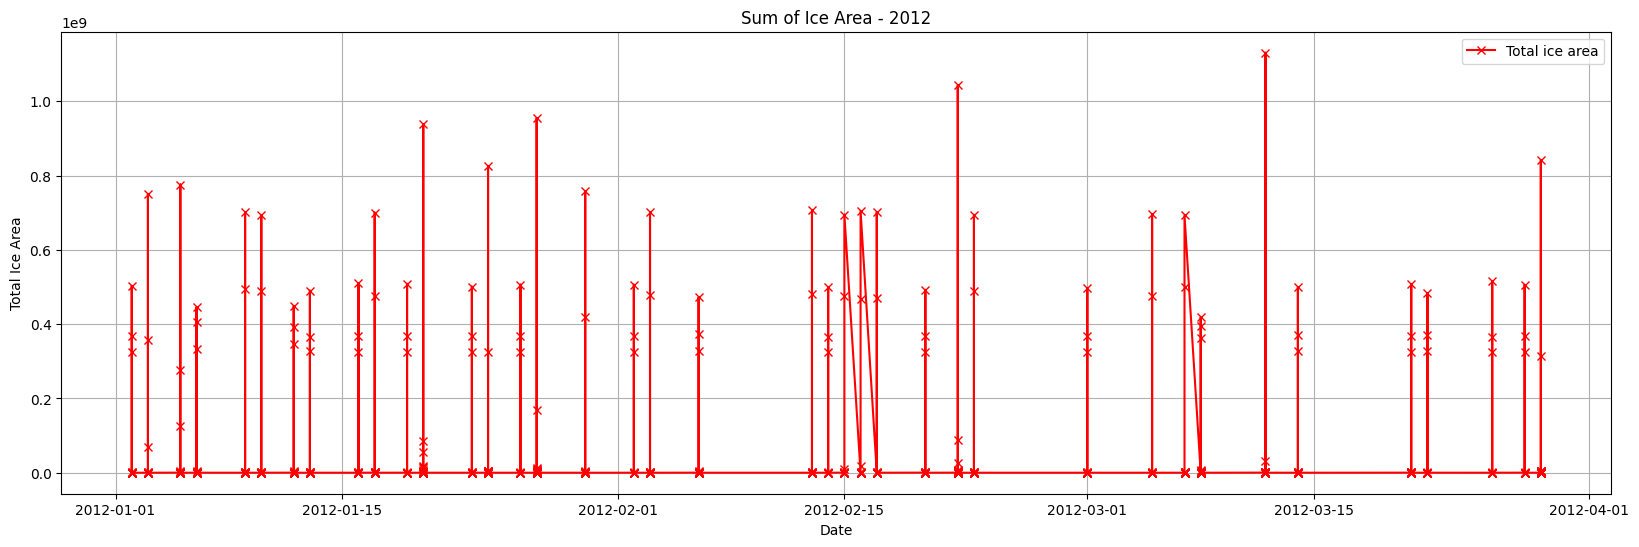

In [8]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(xd['date'], xd['area'], c= 'red', marker='x', label='Total ice area')
# plt.plot(dates, sums, marker='o', label='Total ice area')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
# plt.ylim(0,1.3e6)
plt.title('Sum of Ice Area - 2012')
plt.legend()
plt.grid()
plt.show()

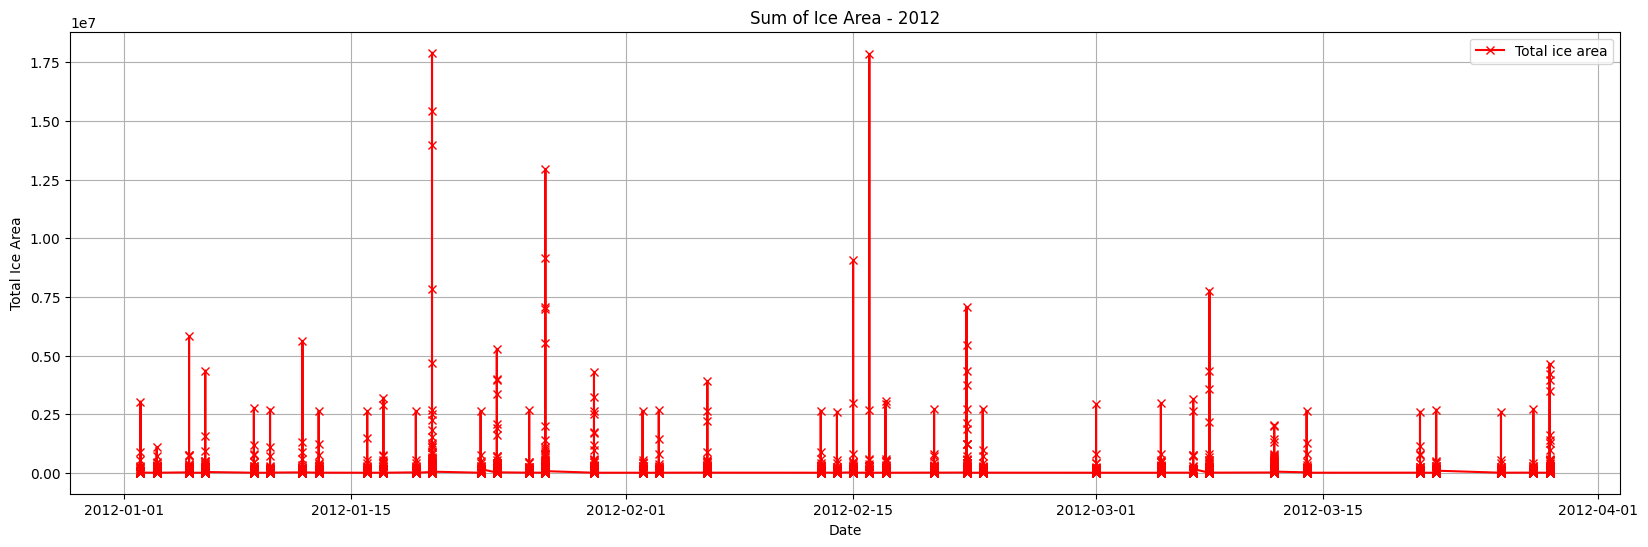

In [9]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(xd_['date'], xd_['area'], c= 'red', marker='x', label='Total ice area')
# plt.plot(dates, sums, marker='o', label='Total ice area')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
# plt.ylim(0,1.3e6)
plt.title('Sum of Ice Area - 2012')
plt.legend()
plt.grid()
plt.show()

In [10]:
result = xd_.groupby(['date', 'value'])['area'].sum().reset_index()
print(result)

         date  value        area
0  2012-01-02    0.0  14067500.0
1  2012-01-02    1.0   1140000.0
2  2012-01-03    0.0  24877500.0
3  2012-01-03    1.0   7987500.0
4  2012-01-05    0.0  17307500.0
..        ...    ...         ...
73 2012-03-26    1.0    372500.0
74 2012-03-28    0.0  14217500.0
75 2012-03-28    1.0    507500.0
76 2012-03-29    0.0  16115000.0
77 2012-03-29    1.0  38612500.0

[78 rows x 3 columns]


In [11]:
ice_area = result[result['value'] == 1] 
print(ice_area)

         date  value         area
1  2012-01-02    1.0    1140000.0
3  2012-01-03    1.0    7987500.0
5  2012-01-05    1.0   16722500.0
7  2012-01-06    1.0   18317500.0
9  2012-01-09    1.0    1452500.0
11 2012-01-10    1.0    1080000.0
13 2012-01-12    1.0   10322500.0
15 2012-01-13    1.0    2537500.0
17 2012-01-16    1.0     727500.0
19 2012-01-17    1.0    2430000.0
21 2012-01-19    1.0     450000.0
23 2012-01-20    1.0  115275000.0
25 2012-01-23    1.0     887500.0
27 2012-01-24    1.0   40202500.0
29 2012-01-26    1.0     477500.0
31 2012-01-27    1.0   79397500.0
33 2012-01-30    1.0   19660000.0
35 2012-02-02    1.0     700000.0
37 2012-02-03    1.0    2940000.0
39 2012-02-06    1.0    4962500.0
41 2012-02-13    1.0    2622500.0
43 2012-02-14    1.0     397500.0
45 2012-02-15    1.0    1415000.0
47 2012-02-16    1.0   19367500.0
49 2012-02-17    1.0    4717500.0
51 2012-02-20    1.0    1035000.0
53 2012-02-22    1.0   51100000.0
55 2012-02-23    1.0    1207500.0
57 2012-03-01 

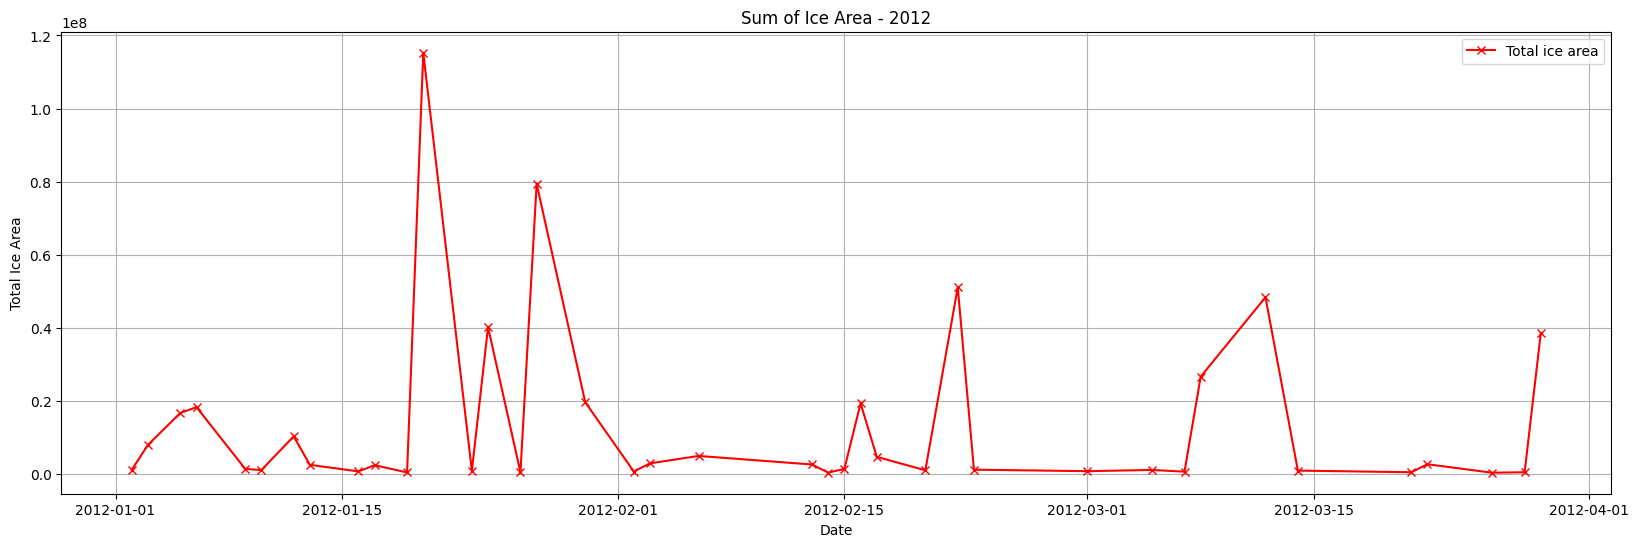

In [12]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(ice_area['date'], ice_area['area'], c= 'red', marker='x', label='Total ice area')
# plt.plot(dates, sums, marker='o', label='Total ice area')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
# plt.ylim(0,1.3e6)
plt.title('Sum of Ice Area - 2012')
plt.legend()
plt.grid()
plt.show()

### Gaussian

In [13]:
input_dir = "C:/Users/jullian.williams/Desktop/HIRLOMAP/binary_maps/z_bin12/z_bin_wint/"

dataframes_ = []

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.tif')):
            input_path = os.path.join(subdir, filename)
             
            with rio.open(input_path) as src_:
                profile = src_.profile  # Save metadata
                transform_ = src_.transform
                crs_=src_.crs
                b1_ = src_.read(1)
                
                def image_to_geodataframe(image_array, transform, crs):
            # Generate shapes (polygons) from the raster array
                    shapes_generator = shapes(image_array, transform=transform_)
                    
                    # Create a GeoDataFrame
                    geometries = []
                    values = []
                    for geom, value in shapes_generator:
                        geometries.append(shape(geom))
                        values.append(value)
                        
                        name, ext = os.path.splitext(filename)
                        raftposition = 8
                    
                        # Create the new file name
                        file_name = f"{filename[:raftposition]}"
                                
                            
                    gdf = gpd.GeoDataFrame({'value': values, 'geometry': geometries, 'date':file_name}, crs=crs_)
                    
                    return gdf 
                    

            gdf['date'] = pd.to_datetime(gdf['date'])
            gdf['area'] = gdf.geometry.area
            gdf['perimeter'] = gdf.geometry.length
            gdf['centroid'] = gdf.geometry.centroid
            # Extract latitude and longitude from centroids
            gdf['longitude'] = gdf.centroid.x
            gdf['latitude'] = gdf.centroid.y
            gdf.set_crs(epsg=32633, inplace=True)

            dataframes_.append(gdf)

In [14]:
xdf_ = pd.concat(dataframes_, ignore_index=True)
print(xdf_)

      value                                           geometry       date  \
0       1.0  POLYGON ((499625 8557925, 499625 8557875, 4995... 2012-01-02   
1       1.0  POLYGON ((522875 8557375, 522875 8557325, 5228... 2012-01-02   
2       1.0  POLYGON ((498975 8556975, 498975 8556825, 4990... 2012-01-02   
3       1.0  POLYGON ((523075 8556725, 523075 8556675, 5231... 2012-01-02   
4       1.0  POLYGON ((523175 8556675, 523175 8556625, 5232... 2012-01-02   
...     ...                                                ...        ...   
6589    1.0  POLYGON ((504825 8531025, 504825 8530975, 5049... 2012-03-29   
6590    1.0  POLYGON ((513125 8531325, 513125 8531275, 5130... 2012-03-29   
6591    1.0  POLYGON ((513975 8531275, 513975 8531225, 5140... 2012-03-29   
6592    1.0  POLYGON ((514975 8531425, 514975 8531325, 5149... 2012-03-29   
6593    0.0  POLYGON ((514525 8531075, 514525 8531025, 5144... 2012-03-29   

          area  perimeter                        centroid      longitude  \

In [15]:
result_ = xdf_.groupby(['date', 'value'])['area'].sum().reset_index()
print(result_)

         date  value          area
0  2012-01-02    0.0  1.260702e+09
1  2012-01-02    1.0  2.950000e+06
2  2012-01-03    0.0  1.196255e+09
3  2012-01-03    1.0  6.739750e+07
4  2012-01-05    0.0  1.237650e+09
..        ...    ...           ...
72 2012-03-26    1.0  1.115950e+08
73 2012-03-28    0.0  1.149862e+09
74 2012-03-28    1.0  1.137900e+08
75 2012-03-29    0.0  1.221042e+09
76 2012-03-29    1.0  4.261000e+07

[77 rows x 3 columns]


In [16]:
ice_area_ = result_[result_['value'] == 1] 
print(ice_area_)

         date  value         area
1  2012-01-02    1.0    2950000.0
3  2012-01-03    1.0   67397500.0
5  2012-01-05    1.0   26002500.0
7  2012-01-06    1.0   16237500.0
9  2012-01-09    1.0   66387500.0
11 2012-01-10    1.0   19847500.0
14 2012-01-13    1.0    7672500.0
16 2012-01-16    1.0    4217500.0
18 2012-01-17    1.0   27532500.0
20 2012-01-19    1.0   19095000.0
22 2012-01-20    1.0   42097500.0
24 2012-01-23    1.0    2357500.0
26 2012-01-24    1.0   11335000.0
28 2012-01-26    1.0   24390000.0
30 2012-01-27    1.0   58415000.0
32 2012-01-30    1.0  104030000.0
34 2012-02-02    1.0   33315000.0
36 2012-02-03    1.0    7682500.0
38 2012-02-06    1.0    7310000.0
40 2012-02-13    1.0   45692500.0
42 2012-02-14    1.0  254352500.0
44 2012-02-15    1.0   67367500.0
46 2012-02-16    1.0   22130000.0
48 2012-02-17    1.0  109587500.0
50 2012-02-20    1.0  104630000.0
52 2012-02-22    1.0  132670000.0
54 2012-02-23    1.0  124772500.0
56 2012-03-01    1.0   72177500.0
58 2012-03-05 

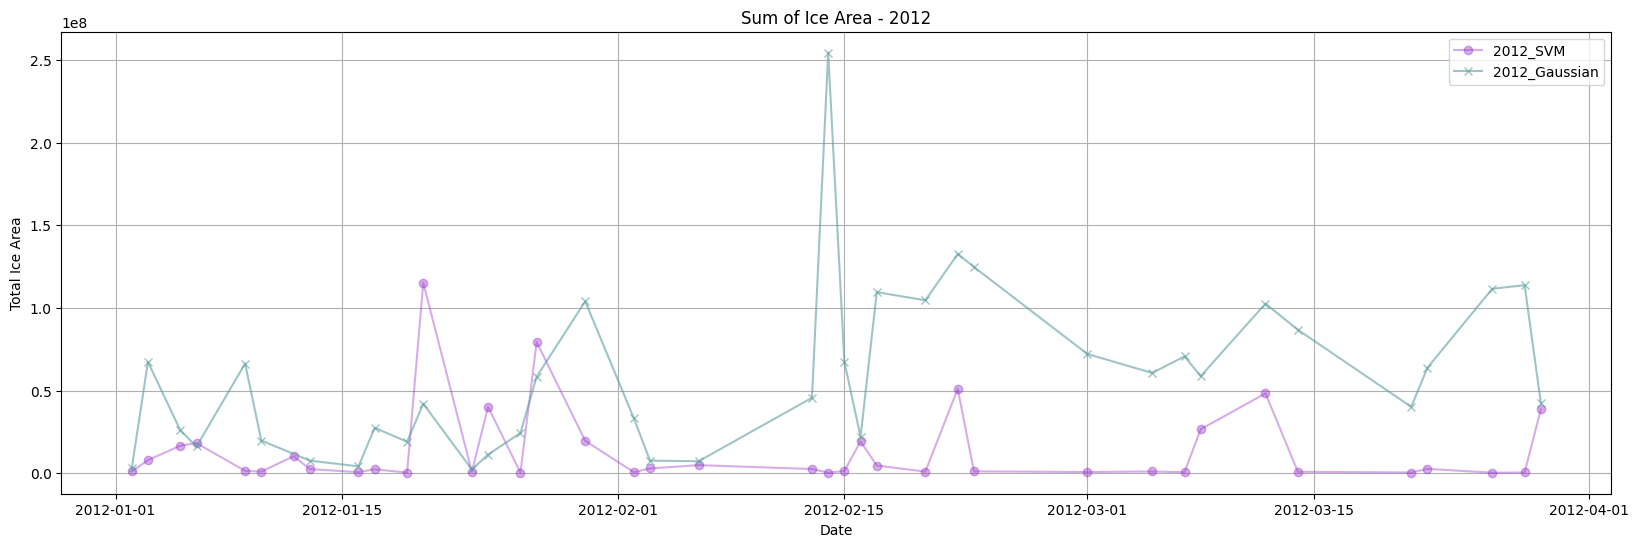

In [17]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(ice_area['date'], ice_area['area'], c='darkorchid', marker='o', alpha=0.4, label='2012_SVM')
plt.plot(ice_area_['date'], ice_area_['area'], c='cadetblue', marker='x', alpha=0.6, label='2012_Gaussian')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
# plt.ylim(0,1.3e6)
plt.title('Sum of Ice Area - 2012')
plt.legend()
plt.grid()
plt.savefig("C:/Users/jullian.williams/Desktop/plots.png", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

### Checking data

In [ ]:
import glob
# Specify the path to the directory containing CSV files
path = "C:/Users/jullian.williams/Desktop/out/"

# Use glob to get all CSV files in the directory
csv_files = glob.glob(path + "/*.csv")

# Create an empty list to store dataframes
dataframes = []

# Loop through the list of CSV files and read each file into a dataframe
for file in csv_files:
    df = pd.read_csv(file)
    dataframes.append(df)

# Concatenate all dataframes into a single dataframe
gdf = pd.concat(dataframes, ignore_index=True)

print(gdf)

In [118]:
gdf['date'] = pd.to_datetime(gdf['date'], format='%Y%m%d')
print(gdf)

      Unnamed: 0  value                                           geometry  \
0              0      0  POLYGON ((499175 8559025, 499175 8558975, 4992...   
1              1      0  POLYGON ((499525 8559025, 499525 8558925, 4995...   
2              2      0  POLYGON ((499675 8559025, 499675 8558925, 4997...   
3              3      0  POLYGON ((499775 8558975, 499775 8558925, 4998...   
4              4      0  POLYGON ((499475 8558925, 499475 8558875, 4995...   
...          ...    ...                                                ...   
5433        3469      0  POLYGON ((501975 8531025, 501975 8530975, 5020...   
5434        3470      0  POLYGON ((509075 8531025, 509075 8530975, 5091...   
5435        3471      0  POLYGON ((509675 8531025, 509675 8530975, 5097...   
5436        3473      0  POLYGON ((512375 8531025, 512375 8530975, 5124...   
5437        3474      0  POLYGON ((513025 8531025, 513025 8530975, 5130...   

           date  area  perimeter                centroid  longi

In [60]:
_0102.loc[_0102['value'] == 1, 'area'].sum()

1140000

In [57]:
_0103.loc[_0103['value'] == 1, 'area'].sum()

7987500

In [ ]:
T_area = gdf.groupby(gdf['date'].dt.date)['area'].sum()
print(T_area)

In [59]:
_0102 = gdf.loc[gdf['date'] == 20120102]
_0103 = gdf.loc[gdf['date'] == 20120103]
print(_0103)

      Unnamed: 0  value                                           geometry  \
1966           0      0  POLYGON ((498975 8559025, 498975 8558975, 4990...   
1967           1      0  POLYGON ((499175 8559025, 499175 8558975, 4993...   
1968           2      0  POLYGON ((499425 8558875, 499425 8558825, 4994...   
1969           3      0  POLYGON ((500075 8558825, 500075 8558725, 5001...   
1970           4      0  POLYGON ((500025 8558675, 500025 8558625, 5000...   
...          ...    ...                                                ...   
5433        3469      0  POLYGON ((501975 8531025, 501975 8530975, 5020...   
5434        3470      0  POLYGON ((509075 8531025, 509075 8530975, 5091...   
5435        3471      0  POLYGON ((509675 8531025, 509675 8530975, 5097...   
5436        3473      0  POLYGON ((512375 8531025, 512375 8530975, 5124...   
5437        3474      0  POLYGON ((513025 8531025, 513025 8530975, 5130...   

          date   area  perimeter                centroid  longi

In [123]:
result = gdf.groupby(['date', 'value'])['area'].sum().reset_index()
print(result)

        date  value       area
0 2012-01-02      0  338767500
1 2012-01-02      1    1140000
2 2012-01-03      0   24877500
3 2012-01-03      1    7987500


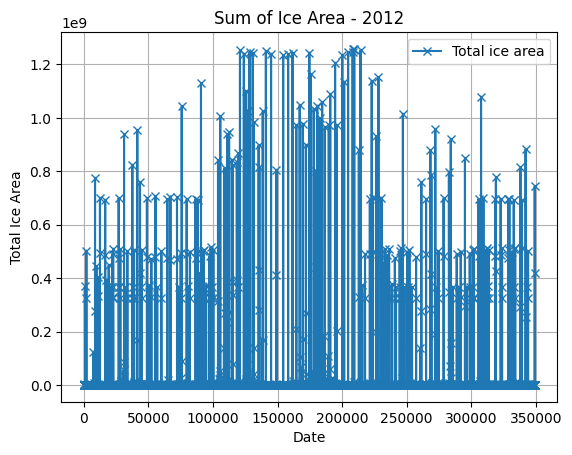

In [172]:
# Plot the results
plt.plot(range(len(gdf['area'])), gdf['area'], marker='x', label='Total ice area')
# plt.plot(dates, sums, marker='o', label='Total ice area')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
# plt.ylim(0,1.3e6)
plt.title('Sum of Ice Area - 2012')
plt.legend()
plt.grid()
plt.show()

In [3]:
input_dir = "C:/Users/jullian.williams/Desktop/out_2/"

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        if filename.endswith(('.csv')):
            input_path = os.path.join(subdir, filename)
              
            with open(input_path) as file:
                gdf_ = pd.read_csv(input_path)
                # print(gdf)

In [ ]:
import glob
# Specify the path to the directory containing CSV files
path = "C:/Users/jullian.williams/Desktop/out_2/"

# Use glob to get all CSV files in the directory
csv_files = glob.glob(path + "/*.csv")

# Create an empty list to store dataframes
dataframes = []

# Loop through the list of CSV files and read each file into a dataframe
for file in csv_files:
    df = pd.read_csv(file)
    dataframes.append(df)

# Concatenate all dataframes into a single dataframe
gdf_ = pd.concat(dataframes, ignore_index=True)

print(gdf_)

In [168]:
gdf_

,Unnamed: 0,value,geometry,date,area,perimeter,centroid,longitude,latitude
0,0,1.0,"POLYGON ((499625 8557925, 499625 8557875, 4995...",20121231,3.750000e+04,900.0,POINT (499626.6666666667 8557783.333333334),499626.666667,8.557783e+06
1,1,1.0,"POLYGON ((522875 8557375, 522875 8557325, 5228...",20121231,1.500000e+04,700.0,POINT (522850 8557275),522850.000000,8.557275e+06
2,2,1.0,"POLYGON ((498975 8556975, 498975 8556825, 4990...",20121231,1.250000e+04,500.0,POINT (499020 8556890),499020.000000,8.556890e+06
3,3,1.0,"POLYGON ((523075 8556725, 523075 8556675, 5231...",20121231,2.500000e+03,200.0,POINT (523100 8556700),523100.000000,8.556700e+06
4,4,1.0,"POLYGON ((523175 8556675, 523175 8556625, 5232...",20121231,2.500000e+03,200.0,POINT (523200 8556650),523200.000000,8.556650e+06
...,...,...,...,...,...,...,...,...,...
25635,305,1.0,"POLYGON ((513575 8531625, 513575 8531475, 5137...",20121231,7.000000e+04,1400.0,POINT (513803.5714285714 8531491.07142857),513803.571429,8.531491e+06
25636,306,1.0,"POLYGON ((512675 8531375, 512675 8531325, 5126...",20121231,4.750000e+04,1400.0,POINT (512728.94736842107 8531147.368421054),512728.947368,8.531147e+06
25637,307,1.0,"POLYGON ((514975 8531425, 514975 8531325, 5149...",20121231,1.350000e+05,2100.0,POINT (515189.81481481483 8531179.629629629),515189.814815,8.531180e+06
25638,308,0.0,"POLYGON ((498975 8559025, 498975 8554125, 4990...",20121231,1.237348e+09,490800.0,POINT (521405.38025898143 8544912.52467477),521405.380259,8.544913e+06


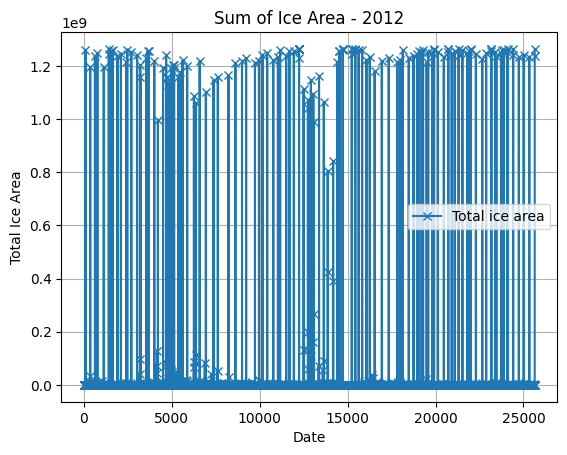

In [169]:
# Plot the results
plt.plot(range(len(gdf_['area'])), gdf_['area'], marker='x', label='Total ice area')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
plt.title('Sum of Ice Area - 2012')
plt.legend()
plt.grid()
plt.show()

## Export to csv

In [ ]:
input_dir = "C:/Users/jullian.williams/Desktop/12_winter/"
output_dir = "C:/Users/jullian.williams/Desktop/x_m/"

# Ensure output directory exists
# os.makedirs(output_dir, exist_ok=True)
dataframes = []

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.tif')):
            input_path = os.path.join(subdir, filename)
            output_path = os.path.join(output_dir, filename.replace(".tif", ".csv"))
             
            with rio.open(input_path) as src_:
                profile = src_.profile  # Save metadata
                transform_ = src_.transform
                crs_=src_.crs
                b1_ = src_.read(1)
                
                def image_to_geodataframe(image_array, transform, crs):
            # Generate shapes (polygons) from the raster array
                    shapes_generator = shapes(image_array, transform=transform_)
                    
                    # Create a GeoDataFrame
                    geometries = []
                    values = []
                    for geom, value in shapes_generator:
                        geometries.append(shape(geom))
                        values.append(value)
                    
                    gdf = gpd.GeoDataFrame({'value': values, 'geometry': geometries}, crs=crs_)
                    
                    return gdf 
                    
                gdf = image_to_geodataframe(b1_, transform=transform_, crs=crs_)

                for filename in os.listdir(input_dir):
                    # Ensure it's a file (not a directory)
                    if os.path.isfile(os.path.join(input_dir, filename)):
                        name, ext = os.path.splitext(filename)
                        raftposition = 8
                    
                    # Create the new file name
                    file_name = f"{filename[:raftposition]}"
                    
                    gdf['date'] = file_name
                    # gdf['date'] = pd.to_datetime(gdf['date'])
                    gdf['area'] = gdf.geometry.area
                    gdf['perimeter'] = gdf.geometry.length
                    gdf['centroid'] = gdf.geometry.centroid
                    # Extract latitude and longitude from centroids
                    gdf['longitude'] = gdf.centroid.x
                    gdf['latitude'] = gdf.centroid.y
                    gdf.set_crs(epsg=32633, inplace=True)

                    # gdf.to_csv(output_path)
                    print(gdf)

In [66]:
input_dir = "C:/Users/jullian.williams/Desktop/HIRLOMAP/binary_maps/z_bin12/z_bin_wint/"
output_dir = "C:/Users/jullian.williams/Desktop/out_2/"

# Ensure output directory exists
# os.makedirs(output_dir, exist_ok=True)
dataframes = []

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.tif')):
            input_path = os.path.join(subdir, filename)
            output_path = os.path.join(output_dir, filename.replace(".tif", ".csv"))
             
            with rio.open(input_path) as src_:
                profile = src_.profile  # Save metadata
                transform_ = src_.transform
                crs_=src_.crs
                b1_ = src_.read(1)
                
                def image_to_geodataframe(image_array, transform, crs):
            # Generate shapes (polygons) from the raster array
                    shapes_generator = shapes(image_array, transform=transform_)
                    
                    # Create a GeoDataFrame
                    geometries = []
                    values = []
                    for geom, value in shapes_generator:
                        geometries.append(shape(geom))
                        values.append(value)
                    
                    gdf = gpd.GeoDataFrame({'value': values, 'geometry': geometries}, crs=crs_)
                    
                    return gdf 
                    
                gdf = image_to_geodataframe(b1_, transform=transform_, crs=crs_)

                for filename in os.listdir(input_dir):
                    # Ensure it's a file (not a directory)
                    if os.path.isfile(os.path.join(input_dir, filename)):
                        name, ext = os.path.splitext(filename)
                        raftposition = 8
                    
                    # Create the new file name
                    file_name = f"{filename[:raftposition]}"
                
                    gdf['date'] = file_name
                    # gdf['date'] = pd.to_datetime(gdf['date'])
                    gdf['area'] = gdf.geometry.area
                    gdf['perimeter'] = gdf.geometry.length
                    gdf['centroid'] = gdf.geometry.centroid
                    # Extract latitude and longitude from centroids
                    gdf['longitude'] = gdf.centroid.x
                    gdf['latitude'] = gdf.centroid.y
                    gdf.set_crs(epsg=32633, inplace=True)
        
                    gdf.to_csv(output_path)
                    # print(gdf)